<a href="https://colab.research.google.com/github/bs3537/DS-Unit-2-Applied-Modeling/blob/master/Bruno_lecture1_Dec_3_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems
- Choose a target to predict, and check its distribution
- Choose what data to hold out for your test set
- Choose an appropriate evaluation metric
- Avoid leakage of information from test to train or from target to features

### Setup

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Classification example: Burrito reviews

From the [Logistic Regression assignment](https://nbviewer.jupyter.org/github/LambdaSchool/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/LS_DS_214_assignment.ipynb) (Unit 2, Sprint 1, Module 4)

In [0]:
import pandas as pd
url = ('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/burritos/burritos.csv')
df = pd.read_csv(url)
print(df.shape)
df.head()

(423, 66)


Location      Burrito       Date  ... Avocado Corn Zucchini
0    Donato's taco shop  California   1/18/2016  ...     NaN  NaN      NaN
1  Oscar's Mexican food  California   1/24/2016  ...     NaN  NaN      NaN
2  Oscar's Mexican food     Carnitas  1/24/2016  ...     NaN  NaN      NaN
3  Oscar's Mexican food  Carne asada  1/24/2016  ...     NaN  NaN      NaN
4          Pollos Maria   California  1/27/2016  ...     NaN  NaN      NaN

[5 rows x 66 columns]

### Choose your target. 

Which column in your tabular dataset will you predict?

In [0]:
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4
df['Great'].describe()

count       421
unique        2
top       False
freq        239
Name: Great, dtype: object

In [0]:
df['Great']

0      False
1      False
2      False
3      False
4       True
       ...  
418    False
419     True
420    False
421     True
422     True
Name: Great, Length: 421, dtype: bool

I've derived my own target to redefine the target (previously 1-5 stars) to a binary classification problem: Predict if a burrito is "Great" or not.

### How is your target distributed?

Classification: How many classes? Are the classes imbalanced?

In [0]:
df['Great'].value_counts(normalize=True)

False    0.567696
True     0.432304
Name: Great, dtype: float64

There are 2 classes, this is a binary classification problem. The majority class occurs with 57% frequency, so this is not too imbalanced. I could just use accuracy score as my evaluation metric.

## Choose your evaluation metric(s)



What are some examples of scenarios where you might favor a high recall or high precision model that identifies "great" burritos?

## Begin to clean and explore your data

#### How many kinds of burritos?

In [0]:
df['Burrito'].nunique()

132

In [0]:
df['Burrito'].unique()

array(['California ', 'Carnitas', 'Carne asada', 'California',
       'combo chicken', 'Monster California', 'Carne Asada',
       'Surf & Turf', 'Chile verde pork', 'battered fish ',
       'Surf and turf ', 'Adobada ', 'Barbacoa', '2 in 1', 'Adobado',
       'Shredded beef', 'Hawaiian', 'Bandido', 'Campeon', 'carne asada',
       'California chicken', 'Azteca', 'Lobster', 'Al pastor', 'Custom',
       'Machaca', 'Quesaburro', 'Philly ', 'Quesa', 'Surf and turf',
       'Mahi', 'Addiction', 'Oaxacalifornia', "Deborah's special",
       'Chicken nopalito', 'Adobada', 'Chicken', 'California Everything',
       'Chile relleno and carnitas', 'California (only cheese)', 'Fish',
       'Chimichanga beef', 'Pastor', 'El Hawaiiano ', 'Shrimp',
       'El Rusio', 'Bacon breakfast', 'Chile Relleno', 'Bomb', 'Arizona',
       'California Burrito', '619 Burrito Original', 'Chicken asada',
       'Carne adobada ', 'Bean and cheese', 'Pokirrito classic ',
       'Mauna Lani', 'Especial ', 'Ranchero

#### Combine Burrito categories

In [0]:
df['Burrito'] = df['Burrito'].str.lower()

In [0]:
df['Burrito'].nunique()

123

In [0]:
california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

In [0]:
df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'
df['Burrito'].value_counts()

California     169
Other          156
Asada           43
Surf & Turf     28
Carnitas        25
Name: Burrito, dtype: int64

#### Drop some high cardinality categoricals

In [0]:
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

#### Deal with missing values

In [0]:
df.isna().sum().sort_values()

Burrito       0
overall       0
Tortilla      0
Great         0
Date          0
           ... 
Ham         419
Lobster     420
Zucchini    420
Carrots     420
Queso       421
Length: 61, dtype: int64

In [0]:
df = df.fillna('Missing')

## Choose which observations you will use to train, validate, and test your model

Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

In [0]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

In [0]:
train = df[df.Date.dt.year <= 2016]
val = df[df.Date.dt.year == 2017]
test = df[df.Date.dt.year >= 2018]

In [0]:
train.shape, val.shape, test.shape

((298, 61), (85, 61), (38, 61))

## Begin to choose which features, if any, to exclude. Would some features "leak" future information?

What happens if we *DON'T* drop features with leakage?

In [0]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

target = 'Great'
features = df.columns.drop([target, 'Date'])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth=3)
)

pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 1.0


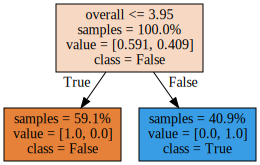

In [0]:
# Visualize decision tree
import graphviz
from sklearn.tree import export_graphviz

tree = pipeline.named_steps['decisiontreeclassifier']

dot_data = export_graphviz(
    tree, 
    out_file=None, 
    feature_names=X_train.columns, 
    class_names=y_train.unique().astype(str), 
    filled=True, 
    impurity=False, 
    proportion=True)

graphviz.Source(dot_data)

In [0]:
# Drop feature with "leakage"
df = df.drop(columns=['overall'])

In [0]:
# Do over
target = 'Great'
features = df.columns.drop([target, 'Date'])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth=3)
)

pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8


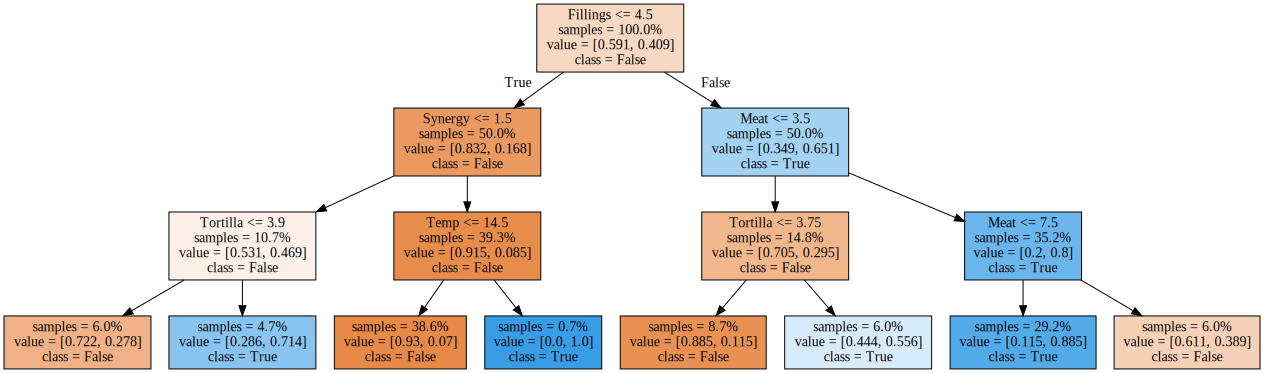

In [0]:
# Visualize decision tree

tree = pipeline.named_steps['decisiontreeclassifier']

dot_data = export_graphviz(
    tree, 
    out_file=None, 
    feature_names=X_train.columns, 
    class_names=y_train.unique().astype(str), 
    filled=True, 
    impurity=False, 
    proportion=True)

graphviz.Source(dot_data)

## Get ROC AUC (Receiver Operating Characteristic, Area Under the Curve)

[Wikipedia explains,](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) "A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. **The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.**"

ROC AUC is the area under the ROC curve. [It can be interpreted](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it) as "the expectation that a uniformly drawn random positive is ranked before a uniformly drawn random negative." 

ROC AUC measures **how well a classifier ranks predicted probabilities.** So, when you get your classifier’s ROC AUC score, you need to **use predicted probabilities, not discrete predictions.**

ROC AUC ranges **from 0 to 1.** Higher is better. A naive majority class **baseline** will have an ROC AUC score of **0.5.** 

#### Scikit-Learn docs
- [User Guide: Receiver operating characteristic (ROC)](https://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc)
- [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- [sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

#### More links
- [ROC curves and Area Under the Curve explained](https://www.dataschool.io/roc-curves-and-auc-explained/)
- [The philosophical argument for using ROC curves](https://lukeoakdenrayner.wordpress.com/2018/01/07/the-philosophical-argument-for-using-roc-curves/)

In [0]:
# "The ROC curve is created by plotting the true positive rate (TPR) 
# against the false positive rate (FPR) 
# at various threshold settings."

# Use scikit-learn to calculate TPR & FPR at various thresholds
from sklearn.metrics import roc_curve
y_pred_proba = pipeline.predict_proba(X_val)[:, -1] # Probability for last class
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

In [0]:
# See the results in a table
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

False Positive Rate  True Positive Rate  Threshold
0             0.000000            0.000000   1.885057
1             0.021277            0.605263   0.885057
2             0.106383            0.657895   0.714286
3             0.127660            0.710526   0.555556
4             0.148936            0.736842   0.388889
5             0.255319            0.789474   0.277778
6             0.276596            0.842105   0.115385
7             1.000000            1.000000   0.069565

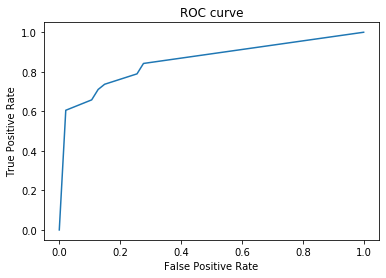

In [0]:
# See the results on a plot. 
# This is the "Receiver Operating Characteristic" curve
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [0]:
# Use scikit-learn to calculate the area under the curve.
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred_proba)

0.8549832026875699

**Recap:** ROC AUC measures how well a classifier ranks predicted probabilities. So, when you get your classifier’s ROC AUC score, you need to use predicted probabilities, not discrete predictions. 

Your code may look something like this:

```python
from sklearn.metrics import roc_auc_score
y_pred_proba = model.predict_proba(X_test_transformed)[:, -1] # Probability for last class
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))
```

ROC AUC ranges from 0 to 1. Higher is better. A naive majority class baseline will have an ROC AUC score of 0.5.

# Regression example: NYC apartments

In [0]:
# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

## Choose your target

Which column in your tabular dataset will you predict?

In [0]:
y = df['price']

## How is your target distributed?

Regression: Is the target right-skewed?

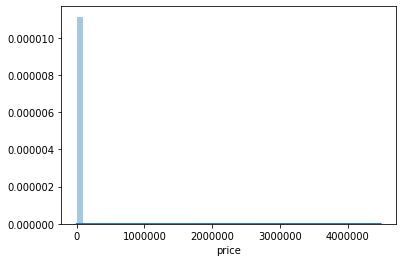

In [0]:
import seaborn as sns
sns.distplot(y)

In [0]:
y.describe()

count    4.935200e+04
mean     3.830174e+03
std      2.206687e+04
min      4.300000e+01
25%      2.500000e+03
50%      3.150000e+03
75%      4.100000e+03
max      4.490000e+06
Name: price, dtype: float64

# Are some observations outliers? 

Will you exclude
them?

In [0]:
# Yes! There are outliers
# Some prices are so high or low it doesn't really make sense.
# Some locations aren't even in New York City.

In [0]:
# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
import numpy as np
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

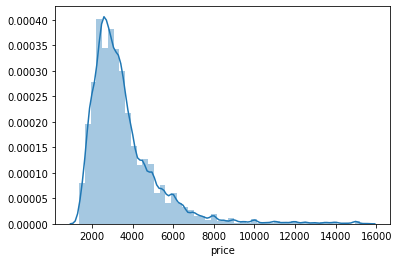

In [0]:
y = df['price']
sns.distplot(y)

In [0]:
y.describe()

count    48817.000000
mean      3579.585247
std       1762.430772
min       1375.000000
25%       2500.000000
50%       3150.000000
75%       4095.000000
max      15500.000000
Name: price, dtype: float64

## Log-Transform

If the target is right-skewed, you may want to "log transform" the target.

In [0]:
import numpy as np
y_log = np.log1p(y)

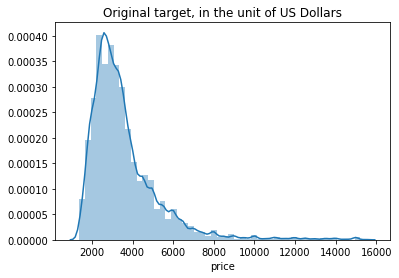

In [0]:
import matplotlib.pyplot as plt
sns.distplot(y)
plt.title('Original target, in the unit of US Dollars');

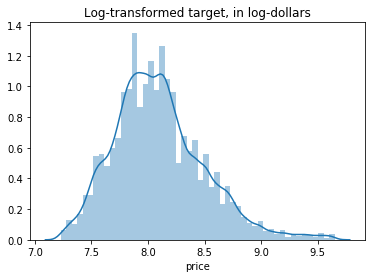

In [0]:
sns.distplot(y_log)
plt.title('Log-transformed target, in log-dollars');

In [0]:
y_untransformed = np.expm1(y_log)
sns.distplot(y_untransformed)
plt.title('Back to the original units');